In [4]:
# %% V3.1 — Imports & Paths
import os, json, joblib, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# Pretty tables
pd.set_option('display.width', 140)
pd.set_option('display.max_columns', 100)

# Project root (works from /scripts or /EDA)
ROOT = Path(os.path.abspath(os.path.join(os.getcwd(), ".."))) if ("EDA" in os.getcwd() or "scripts" in os.getcwd()) else Path(os.getcwd())

# Data & artifacts
DATA_CSV   = ROOT / "data" / "clean_data" / "spotify_features_with_info.csv"  # includes names + features
MODELS_DIR = ROOT / "models"
ART_DIR    = ROOT / "artifacts"
FIG_DIR    = ART_DIR / "figures"
TAB_DIR    = ART_DIR / "tables"

FIG_DIR.mkdir(parents=True, exist_ok=True)
TAB_DIR.mkdir(parents=True, exist_ok=True)

print("ROOT:", ROOT)
print("DATA:", DATA_CSV)
print("FIG_DIR:", FIG_DIR)


ROOT: C:\DS\spotify-MRS
DATA: C:\DS\spotify-MRS\data\clean_data\spotify_features_with_info.csv
FIG_DIR: C:\DS\spotify-MRS\artifacts\figures


In [5]:
# %% V3.2 — Load data & scaler; build scaled features
assert DATA_CSV.exists(), f"Missing: {DATA_CSV}"
df = pd.read_csv(DATA_CSV)

# Identify text cols for display and numeric for math
name_col   = "track_name"  if "track_name"  in df.columns else None
artist_col = "artist_name" if "artist_name" in df.columns else None

exclude_cols = {"popularity","popular_flag","track_id","uri","id","release_date"}
feature_cols = [c for c in df.columns if c not in exclude_cols and pd.api.types.is_numeric_dtype(df[c])]
X = df[feature_cols].copy()

# Load the train-fitted scaler from Day 2
scaler = joblib.load(MODELS_DIR / "scaler.joblib")
X_scaled = scaler.transform(X)

print("Rows, Features:", X_scaled.shape)
print("Example feature cols:", feature_cols[:10])


Rows, Features: (130326, 50)
Example feature cols: ['duration_ms', 'key', 'mode', 'tempo', 'time_signature', 'total_beats', 'energy_sqrt', 'danceability_sqrt', 'valence_sqrt', 'acousticness_sqrt']


In [6]:
# %% V3.3 — Pick a seed & compute neighbors
def match_mask(col, text):
    if col is None or not isinstance(text, str): return np.zeros(len(df), dtype=bool)
    return df[col].fillna("").str.contains(text, case=False, regex=False)

query_track  = "Ghost Town"   # ← change for your demo
query_artist = "Kanye"        # ← optional; set None to ignore

mask = match_mask(name_col, query_track)
if query_artist:
    mask &= match_mask(artist_col, query_artist)

idx = np.where(mask)[0]
assert len(idx) > 0, "Seed track not found. Try relaxing the query text."
seed_idx = int(idx[0])

# Cosine similarity against all
sims = cosine_similarity(X_scaled[seed_idx:seed_idx+1], X_scaled)[0]

# Exclude itself and take top-N
top_n = 15
sims[seed_idx] = -np.inf
top_idx = np.argpartition(-sims, range(top_n))[:top_n]
top_idx = top_idx[np.argsort(-sims[top_idx])]

neighbors = df.iloc[top_idx][[c for c in [name_col, artist_col, "album_name", "popularity"] if c in df.columns]].copy()
neighbors.insert(0, "similarity", sims[top_idx].round(4))
display(neighbors.head(10))

# Save table for README or Streamlit
out_tab = TAB_DIR / "demo_similar_by_track.csv"
neighbors.to_csv(out_tab, index=False)
print("Saved neighbors table ->", out_tab)

print("\nSeed:", df.loc[seed_idx, name_col] if name_col else seed_idx,
      "—", df.loc[seed_idx, artist_col] if artist_col else "")


,similarity,track_name,artist_name,popularity
81675,0.9400,The Bones,Maren Morris,87
79464,0.9389,Fast,Juice WRLD,88
104375,0.9375,FAKE LOVE,BTS,80
104199,0.9370,Watch (feat. Lil Uzi Vert & Kanye West),Travis Scott,73
103819,0.9333,Lucid Dreams,Juice WRLD,91
104388,0.9319,"Zero - From the Original Motion Picture ""Ralph...",Imagine Dragons,77
105046,0.9206,"Back to Life - from ""Bumblebee""",Hailee Steinfeld,75
104175,0.9164,Chlorine,Twenty One Pilots,84
78654,0.9125,Price On My Head (feat. The Weeknd),NAV,81
99074,0.9112,Blame It On Me,Post Malone,76


Saved neighbors table -> C:\DS\spotify-MRS\artifacts\tables\demo_similar_by_track.csv

Seed: Ghost Town — Kanye West


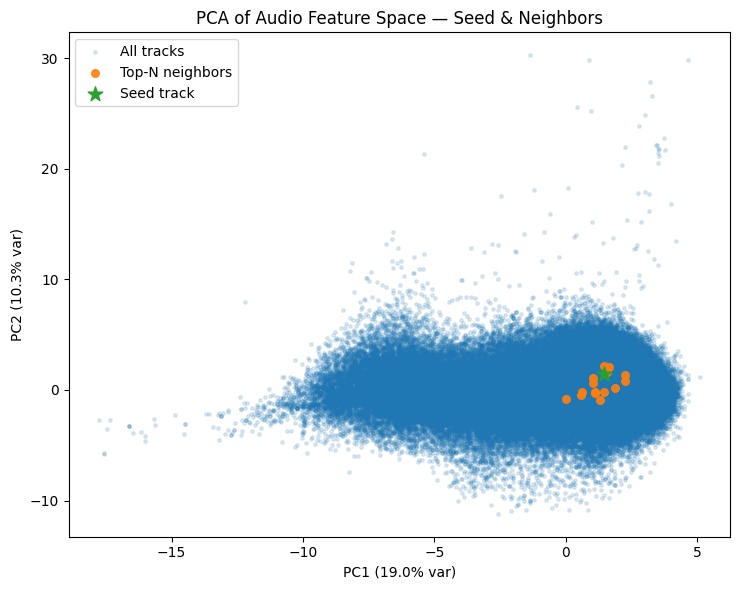

Saved -> C:\DS\spotify-MRS\artifacts\figures\pca_seed_neighbors.png


In [7]:
# %% V3.4 — PCA 2D scatter with seed & neighbors
pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(X_scaled)  # (N,2)

plt.figure(figsize=(7.5,6))
# Plot all points faint
plt.scatter(Z[:,0], Z[:,1], s=6, alpha=0.15, label="All tracks")

# Highlight neighbors
plt.scatter(Z[top_idx,0], Z[top_idx,1], s=30, alpha=0.9, label="Top-N neighbors")

# Highlight seed big marker
plt.scatter(Z[seed_idx,0], Z[seed_idx,1], s=120, marker="*", label="Seed track")

plt.title("PCA of Audio Feature Space — Seed & Neighbors")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.legend(loc="best")
plt.tight_layout()

out_fig = FIG_DIR / "pca_seed_neighbors.png"
plt.savefig(out_fig, dpi=200)
plt.show()
print("Saved ->", out_fig)


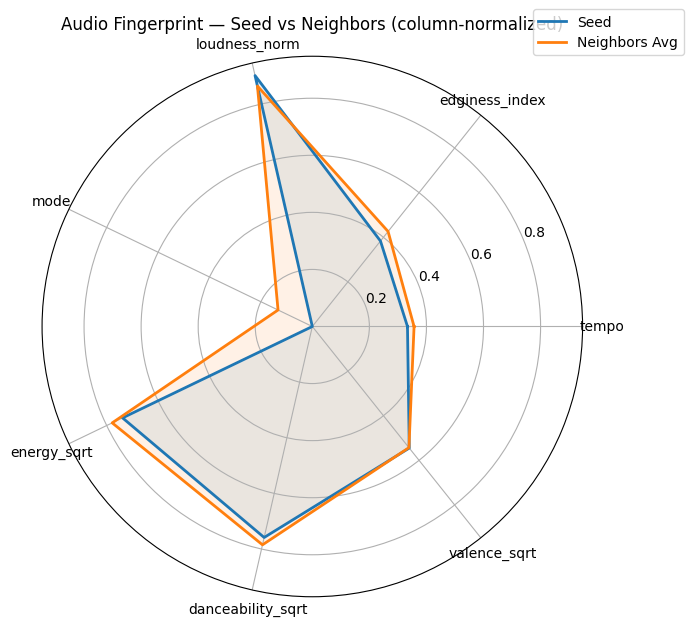

Saved -> C:\DS\spotify-MRS\artifacts\figures\radar_seed_vs_neighbors.png


In [14]:
# %% V3.5 — Robust Radar: seed vs avg neighbors (auto-select features & normalize per-column)
import numpy as np

# 1) Candidate pools in priority order
base_pool = [
    "danceability","energy","valence","acousticness","speechiness","liveness","instrumentalness","tempo"
]
eng_pool = [
    "vibe_intensity","mood_brightness","feelgood_index","party_vibe","edginess_index","chill_index","loudness_norm"
]

# 2) Build radar feature list
radar_feats = [c for c in base_pool if c in df.columns]
if len(radar_feats) < 5:  # not enough base features, extend with engineered
    radar_feats += [c for c in eng_pool if c in df.columns and c not in radar_feats]

# 3) If still short, auto-fill with bounded numeric columns (0..1-ish)
if len(radar_feats) < 5:
    # find numeric columns that look bounded or already normalized
    numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    # avoid clearly non-fingerprint cols
    avoid = set(["popularity","duration_ms"])  # duration & popularity aren't great for fingerprint shape
    candidates = []
    for c in numeric_cols:
        if c in avoid or c in radar_feats:
            continue
        col = df[c].astype(float)
        # heuristics: bounded [0,1] or close; skip wild ranges unless normalized later
        mn, mx = np.nanmin(col), np.nanmax(col)
        if np.isfinite(mn) and np.isfinite(mx) and (0.0 <= mn <= 1.0) and (0.0 <= mx <= 1.0) and (mx > mn):
            candidates.append(c)
    # add up to reach 6–7 total
    for c in candidates:
        if len(radar_feats) >= 7: break
        radar_feats.append(c)

# Final sanity: need at least 4 features
if len(radar_feats) < 4:
    print("Available numeric columns:", [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])][:30])
    raise AssertionError(
        f"Not enough radar features present. Found {len(radar_feats)}. "
        f"Try renaming/including more of: {base_pool + eng_pool}"
    )

# 4) Build seed & neighbor vectors
seed_vec = df.loc[seed_idx, radar_feats].astype(float).values
nbr_vec  = df.loc[top_idx, radar_feats].astype(float).mean(axis=0).values

# 5) Normalize each feature by its column min/max (global), so the radar is comparable
def normalize_by_column(data_matrix, cols):
    data = data_matrix.copy().astype(float)
    mins = np.array([np.nanmin(df[c].astype(float)) for c in cols])
    maxs = np.array([np.nanmax(df[c].astype(float)) for c in cols])
    spans = np.where((maxs - mins) > 0, (maxs - mins), 1.0)
    return (data - mins) / spans

seed_plot = normalize_by_column(seed_vec, radar_feats)
nbr_plot  = normalize_by_column(nbr_vec,  radar_feats)

# 6) Polar plot
labels = radar_feats
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
angles = np.concatenate([angles, angles[:1]])
sv = np.concatenate([seed_plot, seed_plot[:1]])
nv = np.concatenate([nbr_plot,  nbr_plot[:1]])

fig = plt.figure(figsize=(7,7))
ax = plt.subplot(111, polar=True)
ax.plot(angles, sv, linewidth=2, label="Seed")
ax.fill(angles, sv, alpha=0.1)
ax.plot(angles, nv, linewidth=2, label="Neighbors Avg")
ax.fill(angles, nv, alpha=0.1)
ax.set_xticks(angles[:-1]); ax.set_xticklabels(labels)
ax.set_title("Audio Fingerprint — Seed vs Neighbors (column-normalized)")
ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))
plt.tight_layout()

out_fig = FIG_DIR / "radar_seed_vs_neighbors.png"
plt.savefig(out_fig, dpi=200)
plt.show()
print("Saved ->", out_fig)


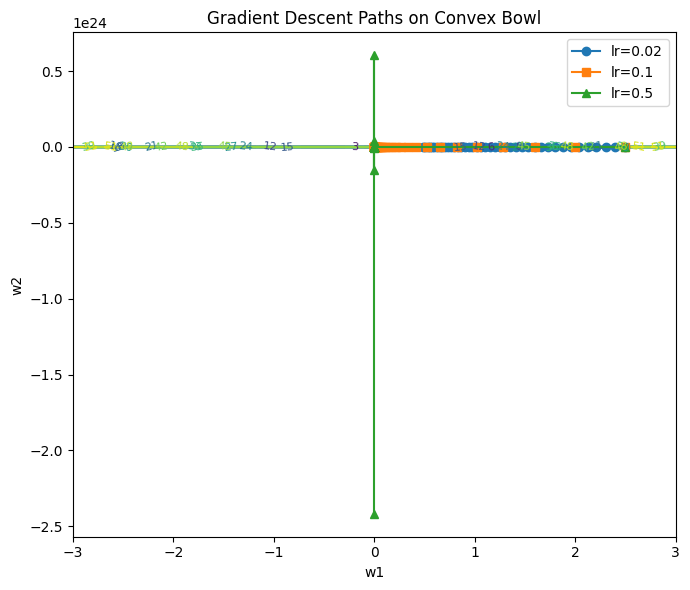

Saved -> C:\DS\spotify-MRS\artifacts\figures\gd_contours_paths.png


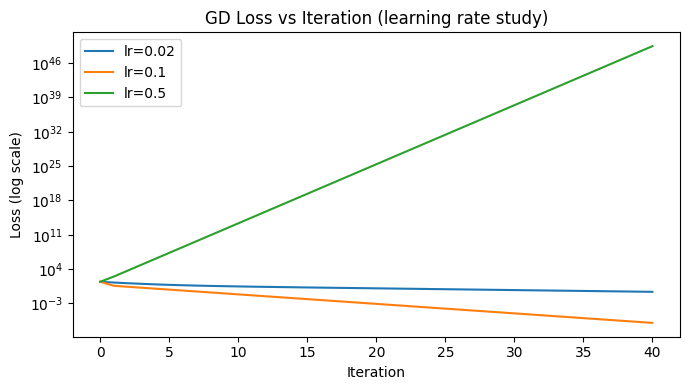

Saved -> C:\DS\spotify-MRS\artifacts\figures\gd_loss_curves.png


In [11]:
# %% V3.6 — Gradient Descent visuals: contours & loss curves (toy problem)
import numpy as np
import matplotlib.pyplot as plt

def quad(w, a=1.0, b=5.0):  # convex bowl
    return a*w[0]**2 + b*w[1]**2

def grad_quad(w, a=1.0, b=5.0):
    return np.array([2*a*w[0], 2*b*w[1]])

def run_gd(w0, lr, steps=40):
    w = w0.copy().astype(float)
    path = [w.copy()]
    losses = [quad(w)]
    for _ in range(steps):
        w -= lr * grad_quad(w)
        path.append(w.copy())
        losses.append(quad(w))
    return np.array(path), np.array(losses)

w0 = np.array([2.5, -2.0])
lrs = [0.02, 0.1, 0.5]
paths_losses = [run_gd(w0, lr) for lr in lrs]

# Contours
xs = np.linspace(-3, 3, 200)
ys = np.linspace(-3, 3, 200)
XX, YY = np.meshgrid(xs, ys)
ZZ = quad(np.array([XX, YY]))

plt.figure(figsize=(7,6))
cs = plt.contour(XX, YY, ZZ, levels=20)
plt.clabel(cs, inline=1, fontsize=8)
markers = ["o", "s", "^"]
for (path, _), lr, m in zip(paths_losses, lrs, markers):
    plt.plot(path[:,0], path[:,1], marker=m, label=f"lr={lr}")
plt.title("Gradient Descent Paths on Convex Bowl")
plt.xlabel("w1"); plt.ylabel("w2"); plt.legend()
plt.tight_layout()
out_fig = FIG_DIR / "gd_contours_paths.png"
plt.savefig(out_fig, dpi=200)
plt.show()
print("Saved ->", out_fig)

# Loss curves
plt.figure(figsize=(7,4))
for (_, losses), lr in zip(paths_losses, lrs):
    plt.plot(losses, label=f"lr={lr}")
plt.yscale("log")
plt.xlabel("Iteration"); plt.ylabel("Loss (log scale)")
plt.title("GD Loss vs Iteration (learning rate study)")
plt.legend(); plt.tight_layout()
out_fig = FIG_DIR / "gd_loss_curves.png"
plt.savefig(out_fig, dpi=200)
plt.show()
print("Saved ->", out_fig)


Existing NN loss figure: True


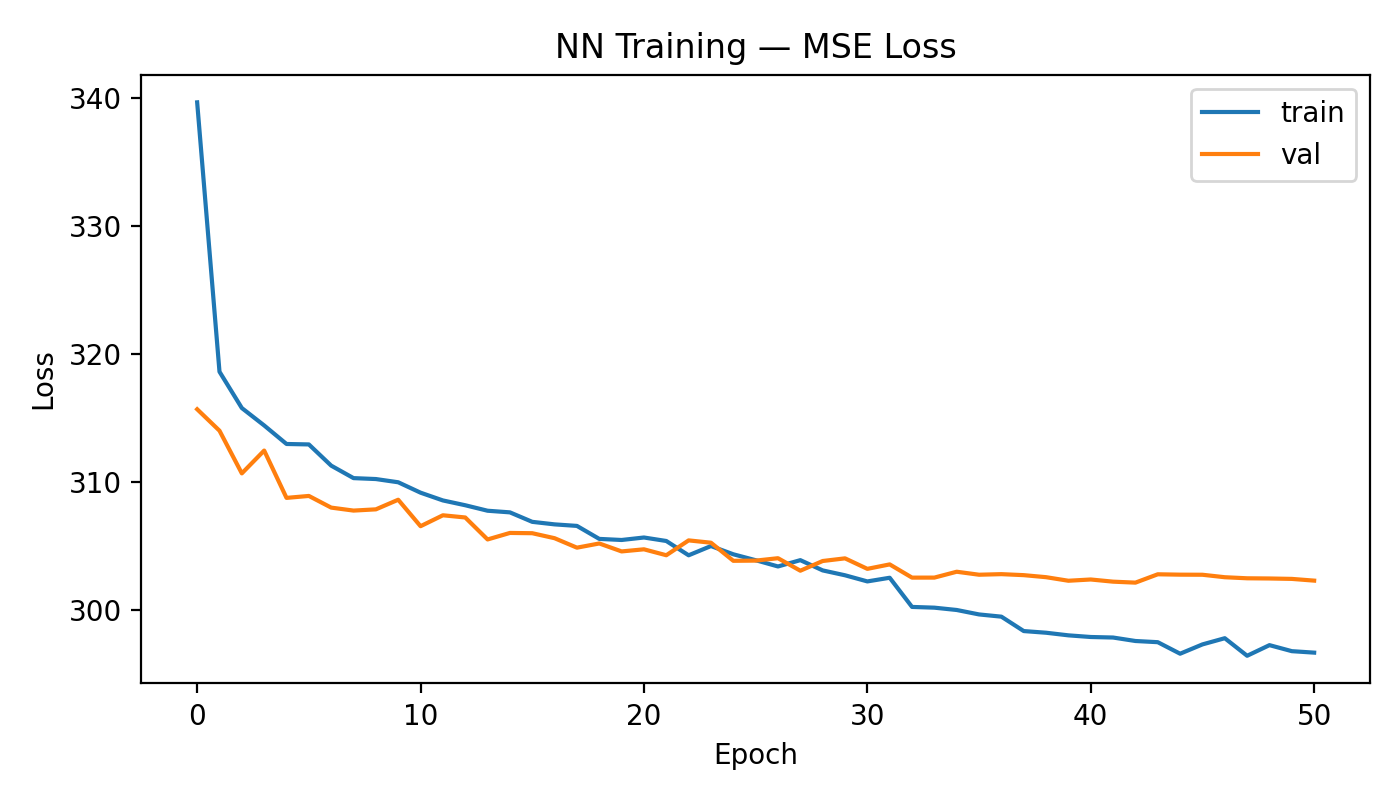

Existing NN MAE figure: True


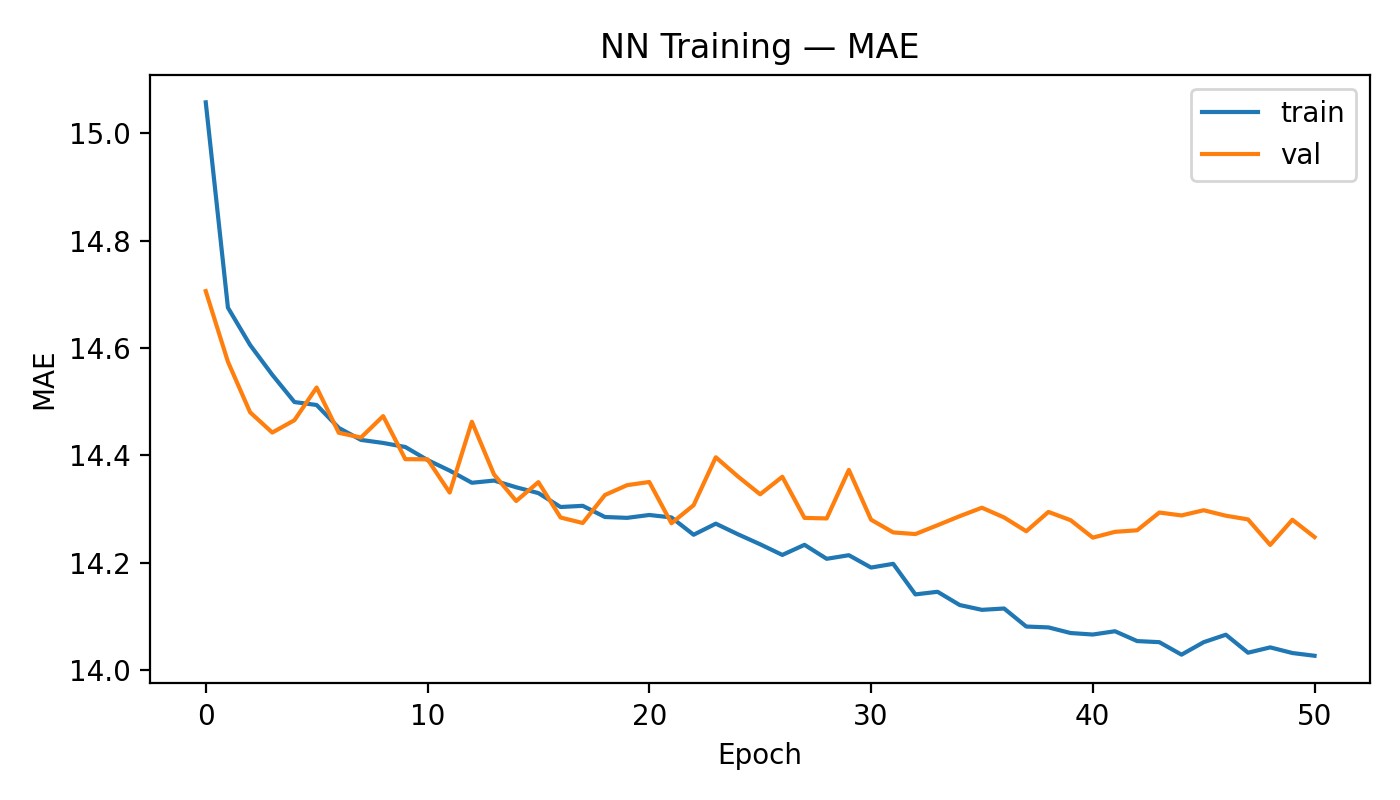

Pred vs Actual figure found: pred_vs_actual_NeuralNet.png


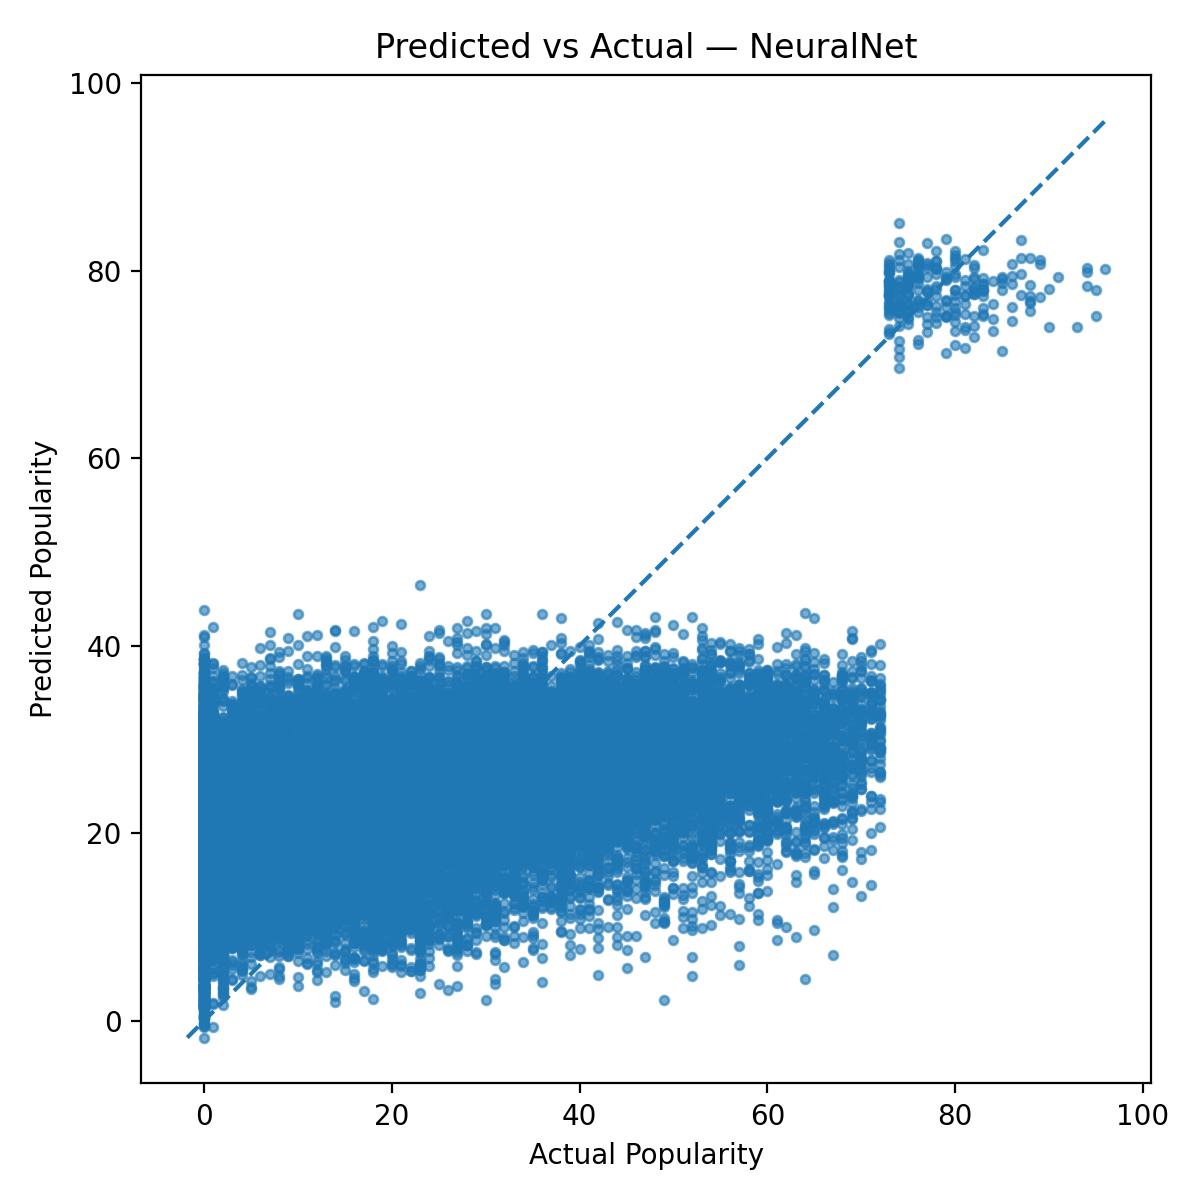

In [12]:
# %% V3.7 — Quick show existing NN figures
from IPython.display import Image, display

nn_loss_png = FIG_DIR / "nn_train_val_loss.png"
nn_mae_png  = FIG_DIR / "nn_train_val_mae.png"
pva_any     = [p for p in FIG_DIR.glob("pred_vs_actual_*.png")]

print("Existing NN loss figure:", nn_loss_png.exists())
if nn_loss_png.exists(): display(Image(filename=str(nn_loss_png)))
print("Existing NN MAE figure:", nn_mae_png.exists())
if nn_mae_png.exists(): display(Image(filename=str(nn_mae_png)))

if pva_any:
    print("Pred vs Actual figure found:", pva_any[0].name)
    display(Image(filename=str(pva_any[0])))
else:
    print("No pred-vs-actual figure found yet. Run Day 2 cells to generate.")


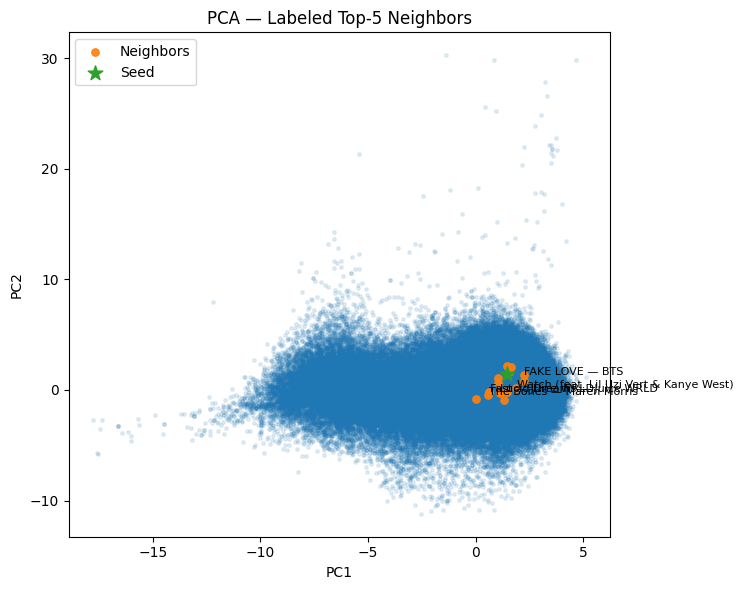

Saved -> C:\DS\spotify-MRS\artifacts\figures\pca_seed_neighbors_labeled.png


In [13]:
# %% V3.8 — Optional: annotate top-5 neighbors on PCA
top5 = top_idx[:5]
plt.figure(figsize=(7.5,6))
plt.scatter(Z[:,0], Z[:,1], s=6, alpha=0.12)
plt.scatter(Z[top_idx,0], Z[top_idx,1], s=28, alpha=0.9, label="Neighbors")
plt.scatter(Z[seed_idx,0], Z[seed_idx,1], s=120, marker="*", label="Seed")
for i in top5:
    label = f"{df.loc[i, name_col]} — {df.loc[i, artist_col]}" if (name_col and artist_col) else str(i)
    plt.text(Z[i,0]+0.02, Z[i,1]+0.02, label[:40], fontsize=8)
plt.title("PCA — Labeled Top-5 Neighbors")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend()
plt.tight_layout()
out_fig = FIG_DIR / "pca_seed_neighbors_labeled.png"
plt.savefig(out_fig, dpi=200)
plt.show()
print("Saved ->", out_fig)
